# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_1m_2f_240216_2"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [80, 1830]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 108000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1650.834822,508.233818,1646.065982,517.602890,NaN,1650.834822,508.233818,NaN,1650.834822,508.233818,-0.177626,11757.0,228.871242,102.683774,0.893706,4
1,1,0,95.409314,821.924665,96.571247,828.002721,NaN,95.409314,821.924665,NaN,95.409314,821.924665,-0.193435,7752.0,230.872862,88.221370,0.924112,4
2,2,0,1615.360218,992.383148,1615.004940,989.232855,0.0,1682.000000,921.000000,0.396078,1634.000000,1006.000000,-0.996830,12473.0,206.539043,83.674270,0.914261,4
3,3,0,505.776600,1044.636042,506.225633,1044.637813,NaN,505.776600,1044.636042,NaN,505.776600,1044.636042,-1.563112,2547.0,188.619934,29.689399,0.987534,4
4,0,3,1650.946275,508.310345,1646.216137,517.693838,NaN,1650.946275,508.310345,NaN,1650.946275,508.310345,-0.174370,11745.0,228.894809,102.687984,0.893720,4
5,1,3,95.655417,822.565973,96.820427,829.154483,NaN,95.655417,822.565973,NaN,95.655417,822.565973,-0.184681,7882.0,231.015464,87.192113,0.926038,4


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 1, 2])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         4  1650.834822   508.233818    -0.177626
1   1     0         4    95.409314   821.924665    -0.193435
2   2     0         4  1615.360218   992.383148    -0.996830
3   3     0         4   505.776600  1044.636042    -1.563112


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1650.834822,508.233818,1646.065982,517.602890,NaN,1650.834822,508.233818,NaN,1650.834822,508.233818,-0.177626,11757.0,228.871242,102.683774,0.893706,4
1,1,0,95.409314,821.924665,96.571247,828.002721,NaN,95.409314,821.924665,NaN,95.409314,821.924665,-0.193435,7752.0,230.872862,88.221370,0.924112,4
2,2,0,1615.360218,992.383148,1615.004940,989.232855,0.0,1682.000000,921.000000,0.396078,1634.000000,1006.000000,-0.996830,12473.0,206.539043,83.674270,0.914261,4
4,0,3,1650.946275,508.310345,1646.216137,517.693838,NaN,1650.946275,508.310345,NaN,1650.946275,508.310345,-0.174370,11745.0,228.894809,102.687984,0.893720,4
5,1,3,95.655417,822.565973,96.820427,829.154483,NaN,95.655417,822.565973,NaN,95.655417,822.565973,-0.184681,7882.0,231.015464,87.192113,0.926038,4
6,2,3,1616.061488,992.555387,1615.985377,989.365039,NaN,1616.061488,992.555387,NaN,1616.061488,992.555387,-0.996441,12539.0,206.578982,84.166098,0.913237,4
7,3,3,505.673153,1045.974414,506.095433,1045.980373,0.0,442.000000,1031.000000,0.647059,503.000000,1067.000000,-1.559897,2775.0,182.826787,34.646866,0.981879,4


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
23482,3,107994,457.336806,1071.912616,457.405386,1071.837524,NaN,457.336806,1071.912616,NaN,457.336806,1071.912616,1.530386,1728.0,137.173022,21.494288,0.987647,4
23483,0,107997,1640.753572,684.799353,1634.616053,675.674164,NaN,1640.753572,684.799353,NaN,1640.753572,684.799353,0.144359,12669.0,220.983314,85.707920,0.921723,4
23484,1,107997,272.514299,665.910160,271.714763,669.132174,NaN,272.514299,665.910160,NaN,272.514299,665.910160,-0.672550,10630.0,200.455841,116.769928,0.812815,4
23485,2,107997,438.282204,939.524267,447.785847,943.223169,NaN,438.282204,939.524267,NaN,438.282204,939.524267,1.271443,14897.0,238.107689,92.237213,0.921922,4
23486,3,107997,457.318916,1071.872549,457.386108,1071.796309,NaN,457.318916,1071.872549,NaN,457.318916,1071.872549,1.529623,1734.0,137.049481,21.583345,0.987521,4


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


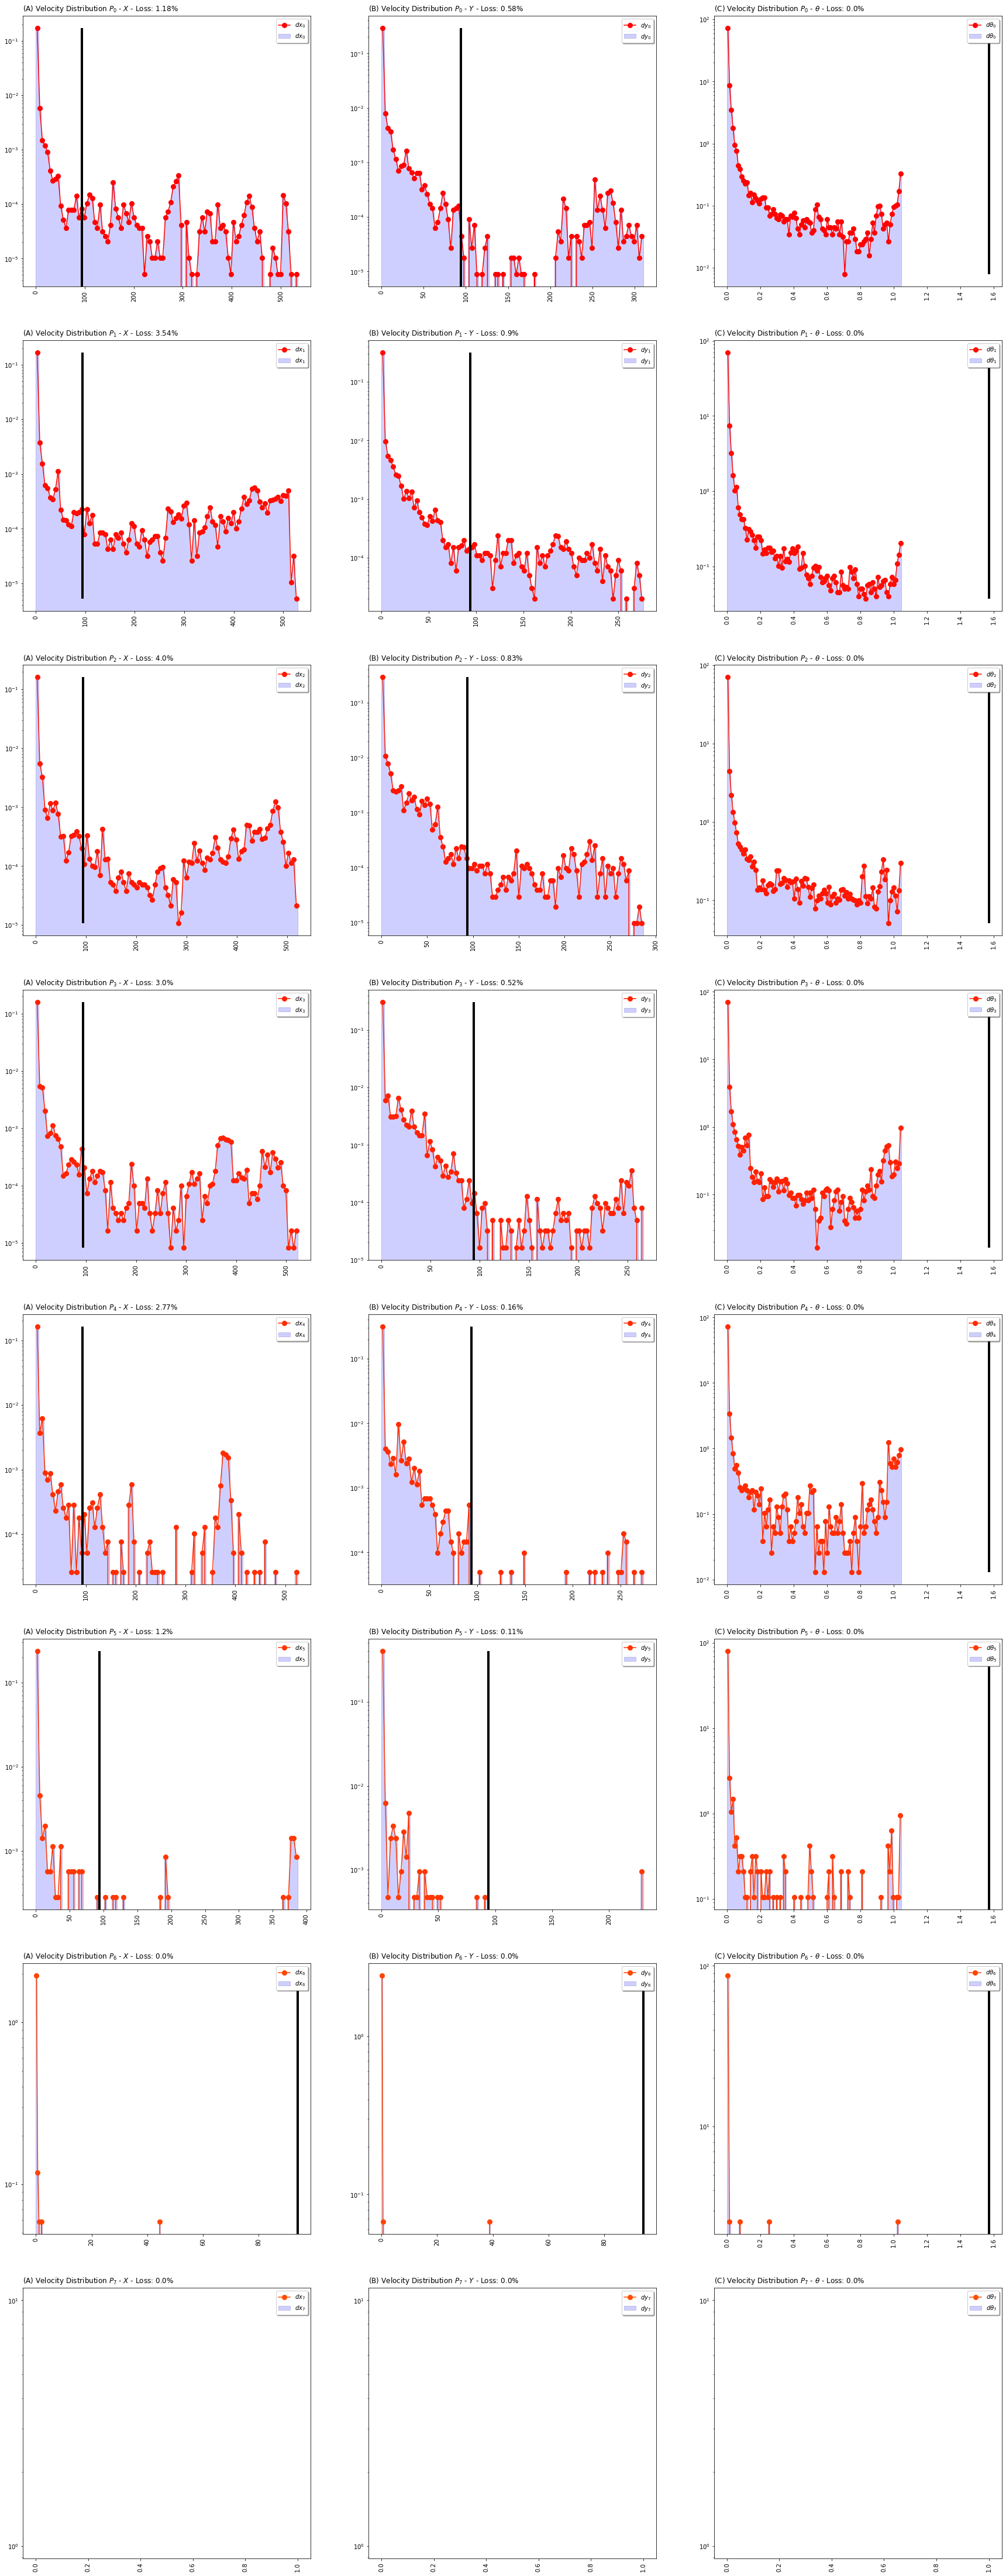

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,440
1,3,37431
2,4,63443
3,5,32640
4,6,5250
5,7,266
6,8,8


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 44.47161348724124 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.299689
1,2,False,True,False,0.002151
2,2,True,False,False,0.012188
3,2,True,True,False,0.001434
4,3,False,False,False,26.022742
5,3,False,True,False,0.144109
6,3,True,False,False,0.529833
7,3,True,True,False,0.139807
8,4,False,False,False,44.183312
9,4,False,True,False,0.165618


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 1.6407304344253433 
	- Angle: 44.47161348724124 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 1.9381701610228823%
Final loss data X-axis: 10.033531080732528%
Final loss data Y-axis: 9.251446258152477%
Final loss data Angle : 1.1846420280776742%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.499281
1,3,False,False,True,5.819116
2,3,False,True,False,0.222005
3,3,False,True,True,3.295995
4,3,True,False,False,0.066325
5,3,True,False,True,2.672353
6,3,True,True,False,0.344523
7,3,True,True,True,85.142231
8,4,False,False,False,0.017502
9,4,False,False,True,0.095803


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 1.6407304344253433 
	- Angle: 44.47161348724124 



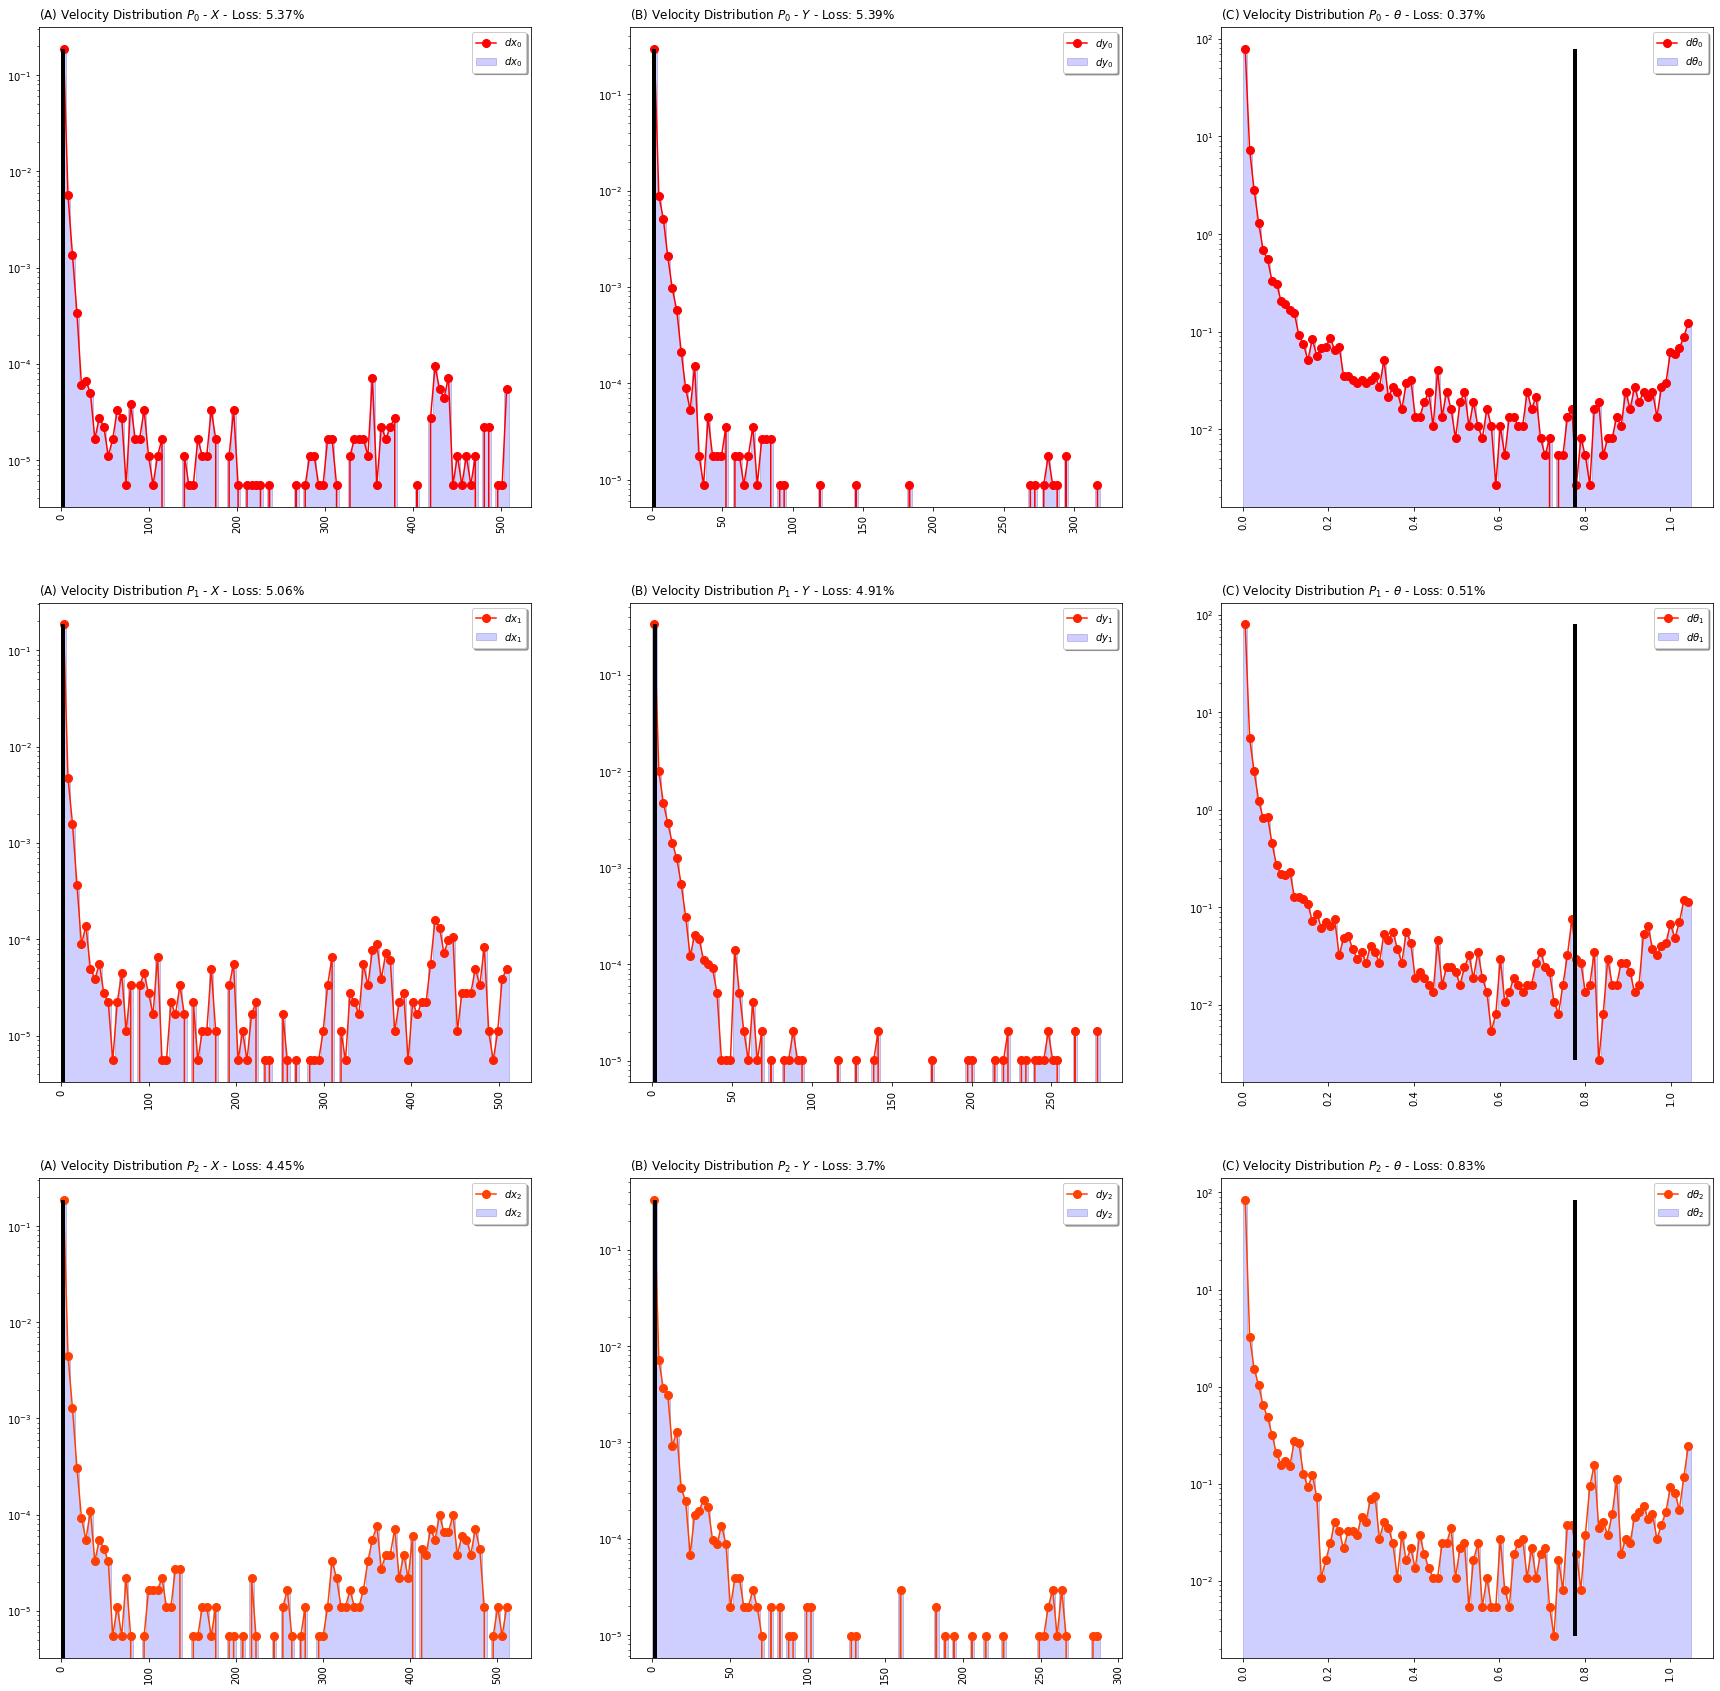

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1650.834822,508.233818,1646.065982,517.602890,NaN,1650.834822,508.233818,NaN,1650.834822,508.233818,-0.177626,11757.0,228.871242,102.683774,0.893706,3,NaN,NaN,NaN,NaN,False,False,False
12477,1,0,95.409314,821.924665,96.571247,828.002721,NaN,95.409314,821.924665,NaN,95.409314,821.924665,-0.193435,7752.0,230.872862,88.221370,0.924112,3,NaN,NaN,NaN,NaN,False,False,False
24954,2,0,1615.360218,992.383148,1615.004940,989.232855,0.0,1682.000000,921.000000,0.396078,1634.000000,1006.000000,-0.996830,12473.0,206.539043,83.674270,0.914261,3,NaN,NaN,NaN,NaN,False,False,False
37431,0,3,1650.946275,508.310345,1646.216137,517.693838,NaN,1650.946275,508.310345,NaN,1650.946275,508.310345,-0.174370,11745.0,228.894809,102.687984,0.893720,3,3.0,0.037151,0.025509,0.001085,False,False,False
37432,1,3,95.655417,822.565973,96.820427,829.154483,NaN,95.655417,822.565973,NaN,95.655417,822.565973,-0.184681,7882.0,231.015464,87.192113,0.926038,3,3.0,0.082035,0.213770,0.002918,False,False,False
37433,2,3,1616.061488,992.555387,1615.985377,989.365039,NaN,1616.061488,992.555387,NaN,1616.061488,992.555387,-0.996441,12539.0,206.578982,84.166098,0.913237,3,3.0,0.233757,0.057413,0.000130,False,False,False
37434,0,6,1651.322730,508.202349,1646.814795,517.536027,NaN,1651.322730,508.202349,NaN,1651.322730,508.202349,-0.168823,11663.0,229.075615,101.962966,0.895478,3,3.0,0.125485,-0.035999,0.001849,False,False,False
37435,1,6,99.006876,809.490764,100.918549,813.560723,NaN,99.006876,809.490764,NaN,99.006876,809.490764,-0.116396,7417.0,153.655115,86.825538,0.825045,3,3.0,1.117153,-4.358403,0.022762,False,False,False
37436,2,6,1616.320003,992.304487,1616.093951,989.024396,0.0,1684.000000,917.000000,0.380392,1644.000000,1012.000000,-0.994193,12503.0,207.910476,83.780913,0.915215,3,3.0,0.086172,-0.083633,0.000750,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_1m_2f_240216_2_c.zip'